1. Download DataSet

In [3]:
import torchvision
import torchvision.transforms as transforms

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

2. Create Custom Dataset for HQ vs Degraded

In [5]:

import torch
from torch.utils.data import Dataset
import numpy as np
import cv2
from PIL import Image

class CIFAR10_HQ_vs_Degraded(Dataset):
    def __init__(self, base_dataset, degrade=False):
        self.base_dataset = base_dataset
        self.degrade = degrade
        self.final_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

    def degrade_image(self, img):
        img_np = np.array(img)
        img_np = cv2.GaussianBlur(img_np, (5, 5), 2)
        noise = np.random.normal(0, 25, img_np.shape).astype(np.uint8)
        img_np = cv2.add(img_np, noise)
        return Image.fromarray(np.clip(img_np, 0, 255).astype('uint8'))

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        img, _ = self.base_dataset[idx]  # PIL image

        if self.degrade:
            img = self.degrade_image(img)
            label = 1  # degraded
        else:
            label = 0  # high-quality

        img = self.final_transform(img)
        return img, label


3. Combine HQ and Degraded Sets

In [6]:
hq_dataset = CIFAR10_HQ_vs_Degraded(trainset, degrade=False)
degraded_dataset = CIFAR10_HQ_vs_Degraded(trainset, degrade=True)

combined_dataset = torch.utils.data.ConcatDataset([hq_dataset, degraded_dataset])
trainloader = torch.utils.data.DataLoader(combined_dataset, batch_size=32, shuffle=True)

4. Load and Modify AlexNet

In [7]:
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

alexnet = models.alexnet(weights=None) 
for param in alexnet.features.parameters():
    param.requires_grad = False  

alexnet.classifier[6] = nn.Linear(4096, 2)  # Binary classification
alexnet = alexnet.to(device)

5. Train the Model

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.parameters(), lr=1e-4)

for epoch in range(10):
    alexnet.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        outputs = alexnet(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    accuracy = 100.0 * correct / total
    print(f"Epoch [{epoch+1}/10], Loss: {total_loss:.4f}, Accuracy: {accuracy:.2f}%")


Epoch [1/10], Loss: 48.2301, Accuracy: 99.42%
Epoch [2/10], Loss: 16.2621, Accuracy: 99.85%
Epoch [3/10], Loss: 13.5656, Accuracy: 99.86%
Epoch [4/10], Loss: 11.9503, Accuracy: 99.89%
Epoch [5/10], Loss: 9.9760, Accuracy: 99.90%
Epoch [6/10], Loss: 8.4559, Accuracy: 99.92%
Epoch [7/10], Loss: 8.3107, Accuracy: 99.91%
Epoch [8/10], Loss: 7.1156, Accuracy: 99.93%
Epoch [9/10], Loss: 7.9150, Accuracy: 99.92%
Epoch [10/10], Loss: 7.5228, Accuracy: 99.92%


6. Save the Model

In [ ]:
torch.save(alexnet.state_dict(), "alexnet_cifar10_degradation.pth")

7. Prepare Test Loader (HQ vs Degraded)

In [8]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd


hq_test   = CIFAR10_HQ_vs_Degraded(testset, degrade=False)
deg_test  = CIFAR10_HQ_vs_Degraded(testset, degrade=True)
test_dataset = torch.utils.data.ConcatDataset([hq_test, deg_test])
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

8. Visualize some HQ vs Degraded test samples

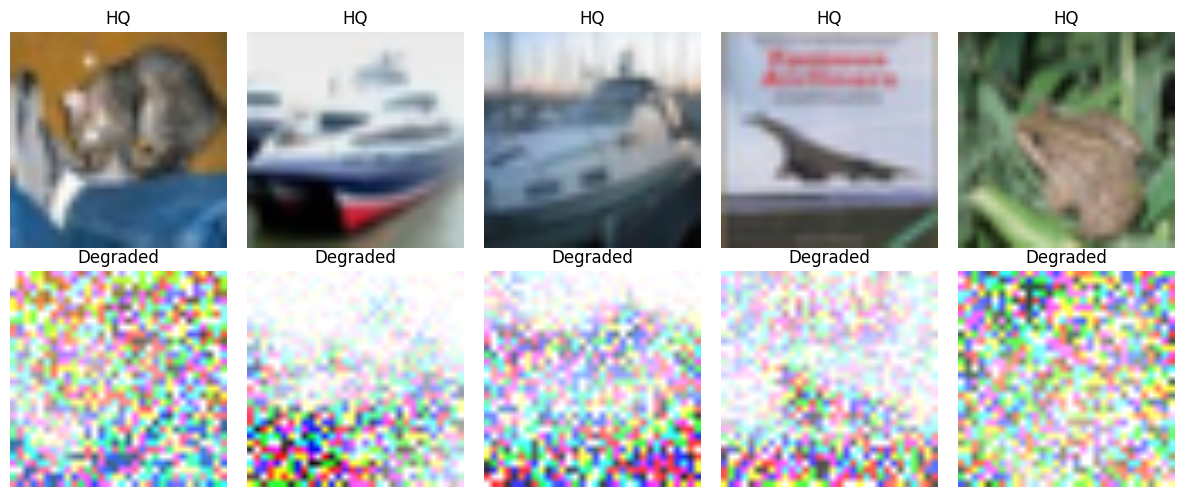

In [34]:

def show_test_samples(dataset, n=5):
    fig, axes = plt.subplots(2, n, figsize=(12, 5))
    for i in range(n):
        img_hq, _ = dataset[i]
        img_deg, _= dataset[i + len(testset)]  # offset into degraded half
        axes[0,i].imshow(img_hq.permute(1,2,0))
        axes[0,i].set_title("HQ")
        axes[0,i].axis('off')
        axes[1,i].imshow(img_deg.permute(1,2,0))
        axes[1,i].set_title("Degraded")
        axes[1,i].axis('off')
    plt.tight_layout()
    plt.show()

combined_test = torch.utils.data.ConcatDataset([hq_test, deg_test])
show_test_samples(combined_test, n=5)

10. Evaluate on Test Set

In [35]:
alexnet.eval()
all_preds  = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = alexnet(images)
        _, preds = torch.max(outputs, dim=1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.tolist())

11. Confusion Matrix

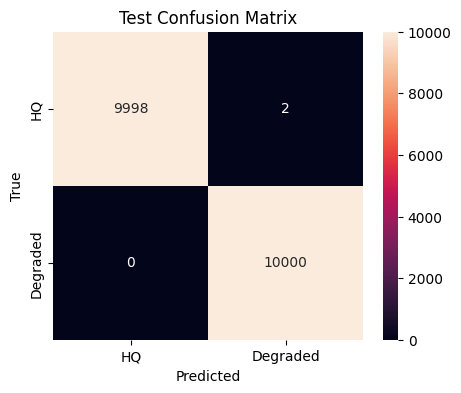

In [36]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=['HQ','Degraded'],
            yticklabels=['HQ','Degraded'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()

12. Classification Report

In [37]:

print(classification_report(all_labels, all_preds,
                            target_names=['High Quality','Degraded']))

              precision    recall  f1-score   support

High Quality       1.00      1.00      1.00     10000
    Degraded       1.00      1.00      1.00     10000

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



13. Inference Function

In [38]:
from PIL import Image

# Recreate the same transform used in training
inference_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

def predict_image(img_path, model, device):

    img = Image.open(img_path).convert('RGB')
    input_tensor = inference_transform(img).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        logits = model(input_tensor)
        probs = torch.softmax(logits, dim=1).cpu().squeeze().tolist()
        label = int(torch.argmax(logits, dim=1).cpu().item())
    return label, probs

14. Export Test Predictions to CSV

In [ ]:
df = pd.DataFrame({
    "TrueLabel":  all_labels,
    "PredLabel":  all_preds
})
df.to_csv("test_predictions_hq_vs_degraded.csv", index=False)
print("Test predictions saved to test_predictions_hq_vs_degraded.csv")

Test predictions saved to test_predictions_hq_vs_degraded.csv


Load Trained Model

In [1]:
import torch
import torchvision.models as models
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

alexnet = models.alexnet(weights=None)
alexnet.classifier[6] = nn.Linear(4096, 2)
alexnet.load_state_dict(torch.load("alexnet_cifar10_degradation.pth", map_location=device))
alexnet = alexnet.to(device)
alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Evaluation on Test Set (Get Predictions + Probs)

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = alexnet(images)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())  # probability for 'Degraded'


ROC Curve & AUC

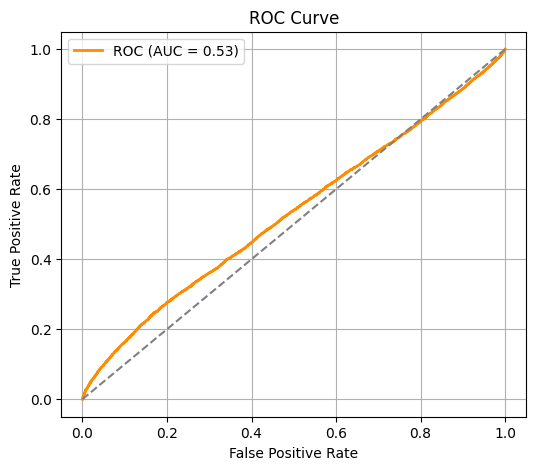

In [10]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


Misclassified Images

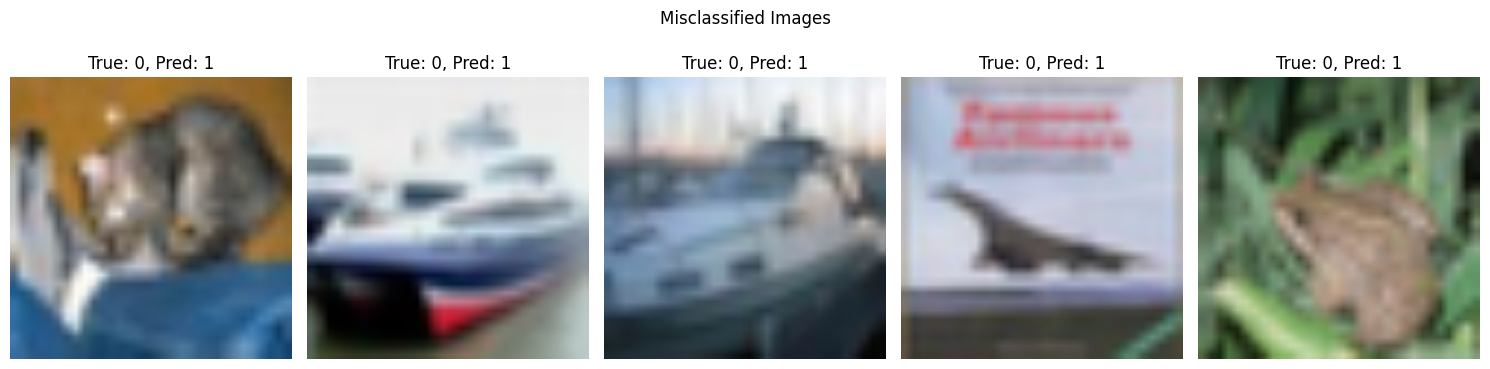

In [11]:
misclassified = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = alexnet(images)
        _, preds = torch.max(outputs, 1)
        for img, pred, label in zip(images.cpu(), preds.cpu(), labels):
            if pred != label:
                misclassified.append((img, pred.item(), label.item()))

# Show a few
n = 5
fig, axes = plt.subplots(1, n, figsize=(15, 4))
for i in range(min(n, len(misclassified))):
    img, pred, label = misclassified[i]
    axes[i].imshow(img.permute(1, 2, 0))
    axes[i].set_title(f"True: {label}, Pred: {pred}")
    axes[i].axis('off')
plt.suptitle("Misclassified Images")
plt.tight_layout()
plt.show()


Feature Map Visualization

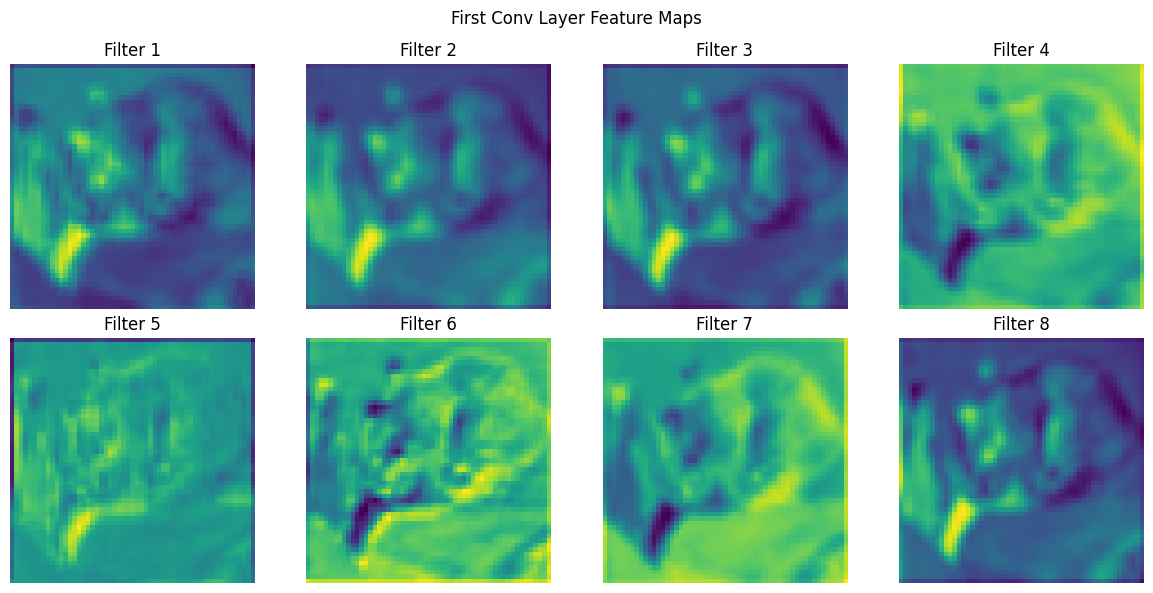

In [12]:
def visualize_feature_maps(model, image_tensor):
    model.eval()
    x = image_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        features = model.features[0](x)

    features = features.cpu().squeeze()
    plt.figure(figsize=(12, 6))
    for i in range(8):
        plt.subplot(2, 4, i+1)
        plt.imshow(features[i], cmap='viridis')
        plt.axis('off')
        plt.title(f'Filter {i+1}')
    plt.suptitle("First Conv Layer Feature Maps")
    plt.tight_layout()
    plt.show()

sample_img, _ = hq_test[0]  # Any HQ image
visualize_feature_maps(alexnet, sample_img)
